In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, spearmanr

import sys
sys.path.append('../..')

from utils.workflow import WorkflowModel
import utils.plotting as plotting
from utils.eval import eval_predictions

2026-02-20 13:43:55.454699: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-20 13:43:57.744789: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-20 13:44:08.403177: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
E0000 00:00:1771605851.187225  806107 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will n

Set the default float type to float64


In [2]:
df = pd.read_csv("../../data/FlunetData_United States of America_All Sites_for_28 October 2024 to 20 October 2025.csv")
df = df.sort_values("Week start date (ISO 8601 calendar)")
df = df[df["Surveillance site type"] == "Non-sentinel"]
df[:5]

,Unnamed: 0,Country area or territory,Surveillance site type,Year-week (ISO 8601 calendar),Week start date (ISO 8601 calendar),Specimen tested,Influenza positive,Influenza negative,A (H1N1)pdm09,A (H3),A (H5),A not subtyped,B (Victoria),B (lineage not determined)
0,1,United States of America,Non-sentinel,2024-44,2024-10-28,75257,917,74340,NaN,NaN,NaN,843,NaN,74
1,2,United States of America,Non-sentinel,2024-45,2024-11-04,76717,1172,75545,NaN,NaN,NaN,1088,NaN,84
2,3,United States of America,Non-sentinel,2024-46,2024-11-11,81959,1730,80229,NaN,NaN,NaN,1604,NaN,126
3,4,United States of America,Non-sentinel,2024-47,2024-11-18,86735,2458,84277,NaN,NaN,NaN,2291,NaN,167
4,5,United States of America,Non-sentinel,2024-48,2024-11-25,83810,3309,80501,NaN,NaN,NaN,3122,NaN,187


In [3]:

I_data = df["Influenza positive"].to_numpy()
I_data

array([  917,  1172,  1730,  2458,  3309,  5064,  9128, 17517, 23900,
       25274, 24600, 33734, 42608, 55042, 56036, 44722, 33909, 25963,
       18573, 14369, 10456,  8372,  6279,  4932,  3947,  3196,  2152,
        1459,  1151,   979,   883,   733,   511,   408,   298,   266,
         253,   142])

In [ ]:
t_0, t_f = 0, len(I_data) - 1
data_t = np.linspace(t_0, t_f, len(I_data))
N = 340000000 # population size
gamma = 1/7

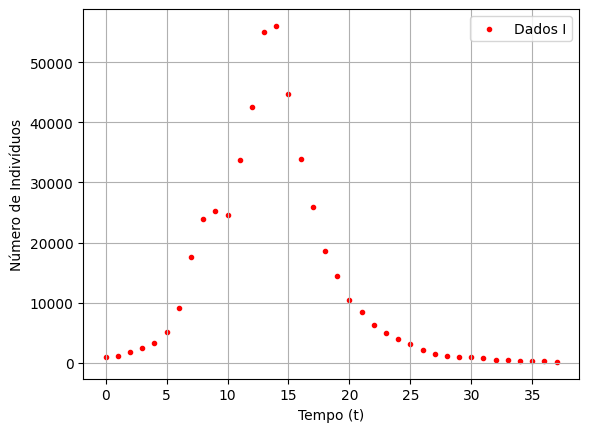

In [5]:
plotting.plot_prevalence_data(data_t, I_data, "data-eua-2025")

In [ ]:
model = WorkflowModel(t_0, t_f, I_data, data_t, N, gamma, 
    activation="tanh",
    n_hidden_layers=3,
    hidden_layer_size=80,
    w_physics=10,
    w_beta_smoothness=1, 
    scaling="min/max",
    # estimate_beta=True,
    beta_estimation_window=5,
    adaptative_wdata=False,
    early_stopping=False)

Compiling model...
'compile' took 0.007880 s



In [7]:
model.scaled_I_data

array([0.01386553, 0.01842774, 0.02841092, 0.04143557, 0.05666082,
       0.08805954, 0.1607686 , 0.31085626, 0.42505457, 0.44963681,
       0.43757827, 0.60099474, 0.75975954, 0.98221634, 1.        ,
       0.79758114, 0.60412567, 0.46196372, 0.32974917, 0.25453537,
       0.18452786, 0.147243  , 0.10979712, 0.08569793, 0.06807529,
       0.05463914, 0.03596093, 0.02356246, 0.01805203, 0.01497477,
       0.01325724, 0.01057359, 0.00660178, 0.00475901, 0.002791  ,
       0.00221848, 0.0019859 , 0.        ])

In [8]:
model.S0, model.I0, model.scaled_N, model.beta0

(np.float64(6082.926306938133),
 np.float64(0.013865531184026909),
 np.float64(6082.940172469317),
 None)

In [9]:
model.train()

(<deepxde.model.LossHistory at 0x7fd54f82a590>,
 <deepxde.model.TrainState at 0x7fd544c33cd0>)

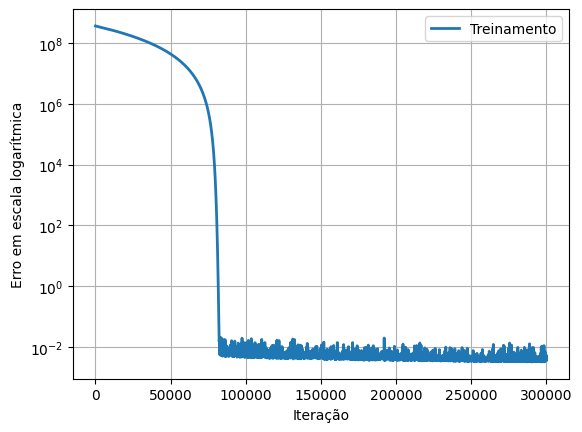

In [10]:
plotting.plot_losshistory(model.losshistory, "loss-eua-2025")

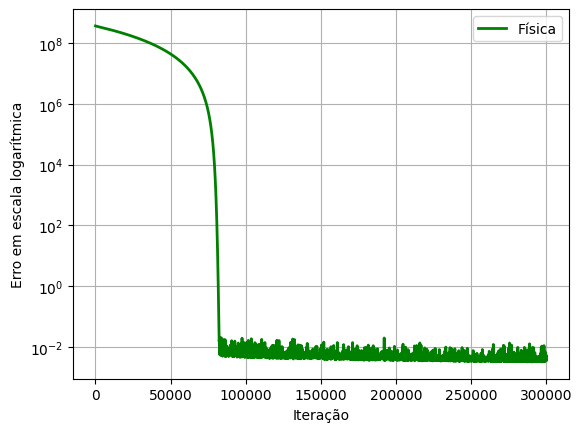

In [11]:
plotting.plot_phys_losshistory(model.losshistory, model.n_physics, "loss-physics-eua-2025")

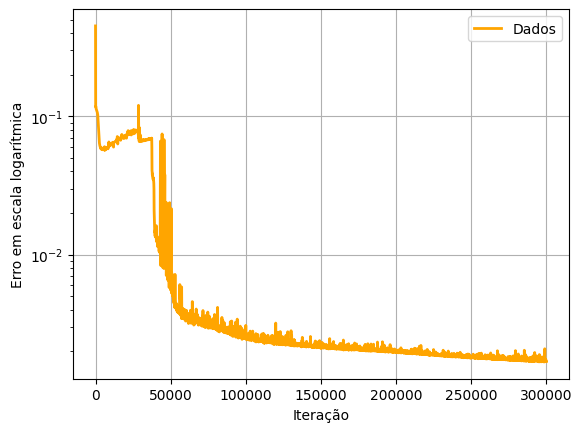

In [12]:
plotting.plot_data_losshistory(model.losshistory, "loss-data-eua-2025")

In [13]:
test_t = np.linspace(t_0, t_f, 50)
pred = model.predict(test_t)

In [14]:
if model.data_weight_hist:
    plotting.plot_wdata(model.data_weight_hist, "wdados-eua-2025")

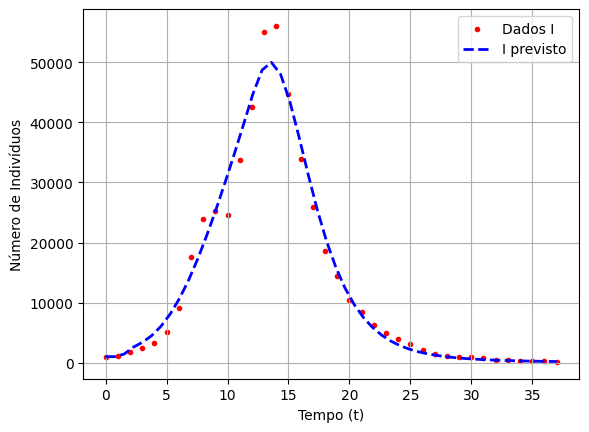

In [15]:
plotting.plot_prevalence_results(I_data, data_t, pred[:,1:2], test_t, "results-eua-2025")

In [16]:
pred[:,2]

array([ 0.34369751,  0.34369751,  0.48970337,  0.5319743 ,  0.52687497,
        0.52006816,  0.51071229,  0.49833046,  0.48293371,  0.46447007,
        0.44314564,  0.41944933,  0.39377314,  0.36640542,  0.33748633,
        0.3054335 ,  0.2652796 ,  0.20966956,  0.13702111,  0.06066514,
       -0.005688  , -0.0593368 , -0.1026326 , -0.13790562, -0.16660731,
       -0.1896584 , -0.20784389, -0.22197892, -0.23287482, -0.24125404,
       -0.24770368, -0.25267589, -0.25651198, -0.25947054, -0.26175024,
       -0.26350578, -0.26485855, -0.26590379, -0.2667158 , -0.26735202,
       -0.26785641, -0.26826225, -0.2685945 , -0.2688717 , -0.26910754,
       -0.26931206, -0.26949261, -0.26965454, -0.26980174, -0.26993706])

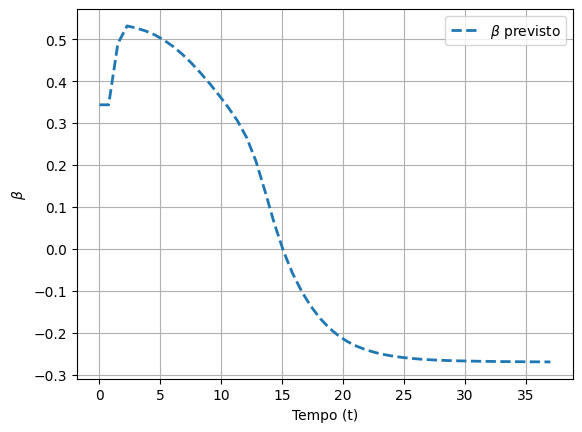

In [17]:
plotting.plot_beta_prediction(pred[:,2], test_t, figname="beta-eua-2025")

In [18]:
pred_eval = model.predict(data_t)
eval_predictions(I_data.reshape(-1,1), pred_eval[:,1].reshape(-1,1), ["I"])

,compartiment,RMSE,L2,L-infinity
0,I,2298.606455,0.11191,6741.977317


In [19]:
model.formated_total_training_time

'00:09:14'

In [21]:
temperature = pd.read_csv("../../data/average-monthly-surface-temperature.csv")
temperature_values = temperature.to_numpy()[:,3].astype("float64")

In [23]:
temperature_values

array([12.209506  ,  4.3120155 ,  0.94223034, -3.0594468 , -0.6777566 ,
        5.5204263 ,  9.870058  , 14.707499  , 20.368093  , 22.689156  ,
       21.348618  , 17.839615  , 11.637465  ])

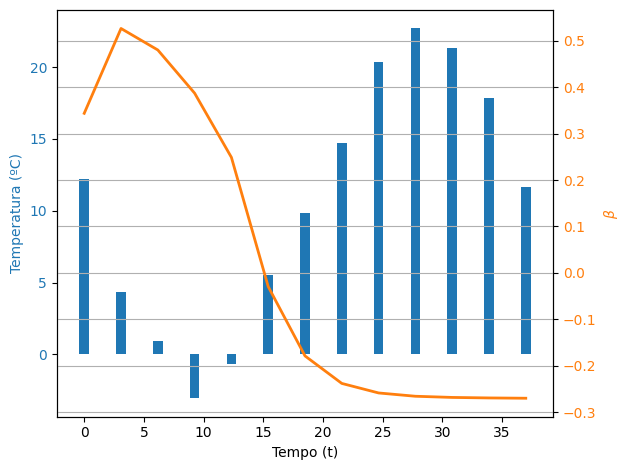

In [24]:


correlation_t = np.linspace(t_0, t_f, len(temperature_values))
pred_beta_correlation = model.predict(correlation_t)[:,2]

plotting.plot_correlation(
    pred_beta_correlation, 
    temperature_values, 
    correlation_t, 
    "Temperatura (ºC)",
    "beta-temperature-correlation"
)

In [25]:
pearson_test = pearsonr(pred_beta_correlation, temperature_values)
pearson_test.statistic, pearson_test.pvalue

(np.float64(-0.7956563592877177), np.float64(0.0011430895531350813))

In [26]:
spearman_test = spearmanr(pred_beta_correlation, temperature_values)
spearman_test.statistic, spearman_test.pvalue

(np.float64(-0.7362637362637362), np.float64(0.004107709360574612))